In [1]:
from IPython.display import Image
import itertools

import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

## Inference Networks with Adaptive Computation

This notebook outlines an idea for using RNN's [with adaptive computation](https://arxiv.org/abs/1603.08983) to produce [mixture posteriors](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.48.5846&rep=rep1&type=pdf) for [Density networks](http://www.inference.org.uk/mackay/ch_learning.pdf).

### 1.  Variational Inference with Mixture Approximations

Recall the method of variational inference.  For an approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi})$--we fit it using the [*Evidence Lower Bound* (ELBO)](http://www.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf): $$ \log p(x) = \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}] + \text{KLD}[q(\boldsymbol{\theta}) || p(\boldsymbol{\theta} | \mathbf{X})] \ge \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}].$$

Often the posteriors we encounter in the wild are multi-modal, and thus using uni-modal posterior approximations can drastically misrepresent the posterior's support.  A straight-forward extentension is to use mixture approximations of the form: $$ q(\boldsymbol{\theta}) = \sum_{k} \pi_{k} q_{k}(\boldsymbol{\theta}) $$ where $\pi_{k}$ is a mixture weight and $q_{k}$ is the kth component density.  Using this approximation, the ELBO can be derived as $$ \log p(\mathbf{X}) \ge \sum_{k} \pi_{k} \mathbb{E}_{q_{k}(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}] $$ where $\mathbb{H}_{q}[\boldsymbol{\theta}] =  -\sum_{k} \pi_{k} \int_{\boldsymbol{\theta}} q_{k}(\boldsymbol{\theta}) \log \sum_{j} \pi_{j} q_{j}(\boldsymbol{\theta}) \ d \boldsymbol{\theta}$, the entropy of the mixture model.  Unfortunately, this quantity is intractable, but we can use the following lower bound proposed by [Gershman et al. (2012)](https://arxiv.org/pdf/1206.4665.pdf): $$ -\sum_{k} \pi_{k} \int_{\boldsymbol{\theta}} q_{k}(\boldsymbol{\theta}) \log \sum_{j} \pi_{j} q_{j}(\boldsymbol{\theta}) \ d \boldsymbol{\theta} \ge -\sum_{k} \pi_{k}  \log \sum_{j} \pi_{j} \int_{\boldsymbol{\theta}} q_{k}(\boldsymbol{\theta}) q_{j}(\boldsymbol{\theta}) \ d \boldsymbol{\theta}, $$ which is attained via straight forward application of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality).  For most common densities, the convolution above can be solved in closed form.  For Gaussians, we have: $$ \int_{\boldsymbol{\theta}} q_{k}(\boldsymbol{\theta}) q_{j}(\boldsymbol{\theta}) \ d \boldsymbol{\theta} = \mathbb{E}_{q_{k}}[q_{j}] = \text{N}(\boldsymbol{\mu}_{k}; \boldsymbol{\mu}_{j}, (\boldsymbol{\sigma}_{k}^{2} + \boldsymbol{\sigma}_{j}^{2})\mathbb{I} ).$$  Intuitively, the convolution term (entropy lower bound) can be seen as encouraging the components to have low probability under one another.  Or in other words, to spread out and diversify their posterior coverage.  Plugging the Gaussian solution back into the ELBO lower bound we have: $$\log p(\mathbf{X}) \ge \mathcal{L}_{\text{ELBO}} \ge   \sum_{k} \pi_{k} \mathbb{E}_{q_{k}(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + -\sum_{k=1}^{K} \pi_{k}  \log \sum_{j=1} \pi_{j} \text{N}(\boldsymbol{\mu}_{k}; \boldsymbol{\mu}_{j}, (\boldsymbol{\sigma}_{k}^{2} + \boldsymbol{\sigma}_{j}^{2})\mathbb{I} ).$$ 


### 2.  Adaptive Inference with RNNs

When using models with per-data-point latent variables of the form $$ \mathbf{z}_{i} \sim p(\mathbf{z}), \ \ \mathbf{x}_{i} \sim p(\mathbf{x}_{i} | \mathbf{z}_{i}),$$ it may be useful to have per-data-point posteriors $q(\mathbf{z}_{i} | \mathbf{x}_{i})$ of varying complexity.  For example, some data points may look like a blend of two different types (for example, a digit that looks like both a one and a seven) and we may wish to place posterior mass on the region of latent space for each digit.  We can define inference networks with this behavior by using an adaptive computation RNN as the inference network.  We propose a network with the following form: $$ \mathbf{h}_{i, t=k} = f_{\text{LSTM}}(\mathbf{h}_{i, t=k-1}, \mathbf{x}_{i}), \ \ \  \boldsymbol{\mu}_{i,k} = f_{\mu}(\mathbf{h}_{i,t=k}), \ \ \  \boldsymbol{\sigma}_{i,k} = f_{\sigma}(\mathbf{h}_{i,t=k}), \ \ \ \gamma_{i,k} = f_{\gamma}(\mathbf{h}_{i,t=k}).$$  The first variable $\mathbf{h}_{i,t=k}$ is simply the RNN's hidden state at time step $k$, as generated by an LSTM unit taking the previous hidden state $\mathbf{h}_{i,t=k-1}$ and the data point $\mathbf{x}_{i}$ as input.  The last three variables are components of the variational mixture approximation.  The first two--$\boldsymbol{\mu}_{i,k}$ and $\boldsymbol{\sigma}_{i,k}$--are the parameters of the kth Gaussian component and are computed via independent functions of the current hidden state.  The last variable is $\gamma_{i,k}$, taking on a value $(0,1)$, and thus would have a logistic function output.  We compose the $\gamma_{i,k}$ variables into the mixture components by using the Dirichlet's [stick breaking construction](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process): $$ \pi_{i,1} = \gamma_{i,1}, \ \ \  \pi_{i,k} = \gamma_{i,k} \prod_{j=1}^{k-1} (1-\gamma_{i,j}).$$  The RNN will hault computation when the remaining stick is less than some threshold, i.e. $\prod_{k=1}^{K} (1-\gamma_{k}) < \epsilon$.  Following [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor), we assume mixtures with few components are preferred, and thus penalize the RNN's computation according to entropy of the mixture weights: $$\mathbb{H}[\boldsymbol{\pi}_{i}] = -\sum_{k=1}^{K} \pi_{i,k} \log \pi_{i,k} = -\sum_{k=1}^{K} \gamma_{i,k} \prod_{j=1}^{k-1} (1-\gamma_{i,j}) [ \log \gamma_{i,k} + \sum_{j=1}^{k-1} \log(1 - \gamma_{i,j}) ].$$

Plugging this term back into the ELBO lower bound in part #1, we have our final objective for the $i$th data point: $$ \mathcal{L}_{\text{ADAPT}}(\mathbf{x}_{i}) = \sum_{k} \pi_{i,k} \mathbb{E}_{q_{k}(\mathbf{z}_{i} | \mathbf{x}_{i})}[ \log p(\mathbf{x}_{i}, \mathbf{z}_{i})] - \sum_{k=1}^{K} \pi_{i,k}  \log \sum_{j=1}^{K} \pi_{i,j} \text{N}(\boldsymbol{\mu}_{i,k}-\boldsymbol{\mu}_{i,j}; \mathbf{0}, (\boldsymbol{\sigma}_{i,k}^{2} + \boldsymbol{\sigma}_{i,j}^{2})\mathbb{I} ) - \mathbb{H}[\boldsymbol{\pi}_{i}].$$

### 3.  Toy Experiment: Approximating a Mixture

We will now implement the above ideas for a toy example in which we approximate a mixture density.  Let's first define a simple mixture...

In [2]:
# Gaussian
def log_normal_pdf(x, mu, sigma):
    d = mu - x
    d2 = tf.mul(-1., tf.mul(d,d))
    s2 = tf.mul(2., tf.mul(sigma,sigma))
    return tf.reduce_sum(tf.div(d2,s2) - tf.log(tf.mul(sigma, 2.506628)))

# Gaussian Mixture
def log_gaussMix_pdf(z, pi, mu, sigma, K):
    s = tf.mul(pi[0], tf.exp(log_normal_pdf(z, mu[0], sigma[0])))
    for k in xrange(K-1):
        s += tf.mul(pi[k+1], tf.exp(log_normal_pdf(z, mu[k+1], sigma[k+1])))
    return tf.log(s)

And plot it...

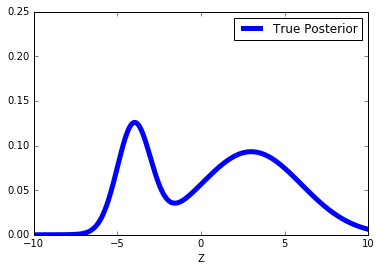

In [3]:
#'true' posterior params
mu_post = [-4., 3.]
sigma_post = [1., 3.]
pi_post = [.3, .7]

Z = tf.placeholder(tf.float32, shape=(), name="init")
log_prob_z = log_gaussMix_pdf(Z, pi_post, mu_post, sigma_post, 2)

# get posterior probabilities
z_grid = np.linspace(-10., 10., 1000).astype('float32')
with tf.Session() as session:
    probs_true = np.exp([session.run(log_prob_z, {Z: z}) for z in z_grid])

plt.figure()

plt.plot(z_grid, probs_true, 'b-', linewidth=5, label="True Posterior")

plt.xlabel("Z")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

Now let's define our adaptive inference RNN, starting with the recurrent component...

In [4]:
# define dimensionality of model components
input_d = 1
rnn_hidden_d = 5
z_space_d = 1

max_n_loops = 10

# init data variable
X = tf.placeholder("float", [None, input_d])

# init RNN params
params = {'h':{'W':tf.Variable(tf.random_normal([input_d, rnn_hidden_d], stddev=.00001)),
               'U':tf.Variable(tf.random_normal([rnn_hidden_d, rnn_hidden_d], stddev=.00001)),
               'b':tf.Variable(tf.zeros([rnn_hidden_d,]))
              },
          'mu':{'W':tf.Variable(tf.random_normal([rnn_hidden_d, z_space_d], stddev=.00001)),
               'b':tf.Variable(tf.zeros([z_space_d,]))
              },
          'sigma':{'W':tf.Variable(tf.random_normal([rnn_hidden_d, z_space_d], stddev=.00001)),
               'b':tf.Variable(tf.zeros([z_space_d,]))
              },
          'pi':{'W':tf.Variable(tf.random_normal([rnn_hidden_d, 1], stddev=.00001)),
               'b':tf.Variable(tf.zeros([1,]))
              }
        }


### DEFINE RNN LOOP ###
def prop_RNN(hidden_state):

    # Defines an Elman network
    # TODO: define LSTM cell
    hidden_state = \
    tf.nn.relu(tf.matmul(X, params['h']['W']) + tf.matmul(hidden_state, params['h']['U']) + params['h']['b'])
    
    return hidden_state

hidden_states = [tf.zeros([tf.shape(X)[0], rnn_hidden_d])]

for loop_idx in range(max_n_loops):
    hidden_states.append( prop_RNN(hidden_states[-1]) )
    
# remove inital state
hidden_states = hidden_states[1:]

Next we take the hidden states and determine how many components to compute...

In [5]:
pis = []
mus = []
sigmas = []
remaining_stick = 1.

stick_eps = .01
for idx in range(max_n_loops):
    
    # compute component params
    mus.append(tf.matmul(hidden_states[idx], params['mu']['W']) + params['mu']['b'])
    sigmas.append(tf.nn.softplus(tf.matmul(hidden_states[idx], params['sigma']['W']) + params['sigma']['b']))
    
    # compute component weights
    gamma = tf.nn.sigmoid(tf.matmul(hidden_states[idx], params['pi']['W']) + params['pi']['b'])
    pis.append(gamma * remaining_stick)
    
    # update 
    remaining_stick = (1.-gamma) * remaining_stick
    remaining_stick = tf.cond( tf.reduce_max(remaining_stick) < stick_eps, lambda: 0.*remaining_stick, lambda: remaining_stick )

Now let's define our optimization function...

In [10]:
# data term: \sum_k \pi_k E[log p(x,z)]
expected_ll = 0.
pi_sum_tracker = 0.
for k in range(max_n_loops):
    z_sample = mus[k] + sigmas[k] * tf.random_normal(shape=[tf.shape(X)[0], z_space_d])
    expected_ll += pis[k] * log_gaussMix_pdf(z_sample, pi_post, mu_post, sigma_post, 2)
    
# entropy lower bound term : -\sum_k pi_k log \sum_j pi_j N(mu_k; mu_j, sigma_k**2 + sigma_j**2)
ent_lb_term = 0.
for k in range(max_n_loops):
    temp_val = 0.
    for j in range(max_n_loops):
        temp_val += pis[j] * tf.exp(log_normal_pdf(mus[k], mus[j], tf.sqrt(sigmas[k]**2 + sigmas[j]**2)))
    ent_lb_term += -pis[k] * tf.log(temp_val + .0001)
    
# entropy of mixture weights
ent_mix_weights = 0.
for k in range(max_n_loops):
    ent_mix_weights += -pis[k] * tf.log(pis[k] + .001)
    
# final objective
objective_fn = tf.reduce_mean(expected_ll + ent_lb_term - ent_mix_weights)

# collect parameters
final_pis = tf.concat(2, [tf.expand_dims(t, 2) for t in pis])
final_mus = tf.concat(2, [tf.expand_dims(t, 2) for t in mus])
final_sigmas = tf.concat(2, [tf.expand_dims(t, 2) for t in sigmas])

Lastly, let's train our dynamic RNN approximation...

In [11]:
# Set training params
n_epochs = 500
learning_rate = .005

# get the training operator
train_model = tf.train.AdamOptimizer(learning_rate).minimize(-objective_fn, \
                    var_list=[params['h']['W'], params['h']['U'], params['h']['b'], 
                     params['mu']['W'], params['mu']['b'],
                      params['sigma']['W'], params['sigma']['b'],
                      params['pi']['W'], params['pi']['b']])


with tf.Session() as session:
    tf.initialize_all_variables().run()
    
    obj_tracker = 0.
    for epoch_idx in xrange(n_epochs):
        
        # perform update
        _, obj, ll, ent_lb, ent_mix = session.run([train_model, objective_fn, expected_ll, ent_lb_term, ent_mix_weights], feed_dict={X: np.ones((5,1))})
        obj_tracker += obj
    
        if (epoch_idx+1) % 10 == 0:
            print "Epoch %d.  VI Objective: %.3f" %(epoch_idx+1, obj_tracker/10)
            obj_tracker = 0.

    m, s, p = session.run([final_mus, final_sigmas, final_pis], feed_dict={X: np.ones((5,1))})

Epoch 10.  VI Objective: -9.777
Epoch 20.  VI Objective: -9.467
Epoch 30.  VI Objective: -8.918
Epoch 40.  VI Objective: -8.340
Epoch 50.  VI Objective: -7.805
Epoch 60.  VI Objective: -7.019
Epoch 70.  VI Objective: -6.679
Epoch 80.  VI Objective: -5.688
Epoch 90.  VI Objective: -5.124
Epoch 100.  VI Objective: -4.579
Epoch 110.  VI Objective: -4.188
Epoch 120.  VI Objective: -3.791
Epoch 130.  VI Objective: -3.868
Epoch 140.  VI Objective: -3.690
Epoch 150.  VI Objective: -3.202
Epoch 160.  VI Objective: -3.333
Epoch 170.  VI Objective: -3.271
Epoch 180.  VI Objective: -2.949
Epoch 190.  VI Objective: -3.399
Epoch 200.  VI Objective: -3.326
Epoch 210.  VI Objective: -3.036
Epoch 220.  VI Objective: -3.111
Epoch 230.  VI Objective: -3.287
Epoch 240.  VI Objective: -2.638
Epoch 250.  VI Objective: -3.033
Epoch 260.  VI Objective: -2.831
Epoch 270.  VI Objective: -2.845
Epoch 280.  VI Objective: -2.785
Epoch 290.  VI Objective: -3.009
Epoch 300.  VI Objective: -3.329
Epoch 310.  VI Obje

The first axis just holds a fake mini-batch. Just throw it away...

In [12]:
m, s, p = m[0, :, :], s[0, :, :], p[0, :, :]

print "Mu: "+str(m)
print "Sigma: "+str(s)
print "Pis: "+str(p)

Mu: [[ 2.98410678  3.79011273  4.07391834  4.17385006  4.20903778  4.22142744
   4.22579002  4.22732639  4.22786713  4.22805738]]
Sigma: [[ 1.88850713  2.2777555   2.41951036  2.46991181  2.48771548  2.49399114
   2.49620199  2.49698043  2.49725437  2.49735093]]
Pis: [[ 0.9900108  0.         0.         0.         0.         0.         0.         0.
   0.         0.       ]]


Let's visualize the approximation...

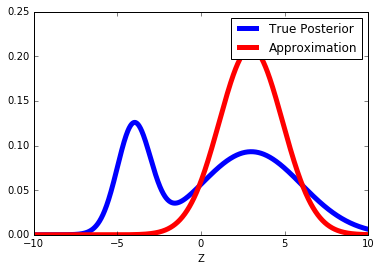

In [13]:
from scipy.stats import norm

probs_approx = [np.sum([p[0,k] * norm.pdf(z, loc=m[0, k], scale=s[0,k]) for k in range(max_n_loops)]) for z in z_grid]

plt.figure()

plt.plot(z_grid, probs_true, 'b-', linewidth=5, label="True Posterior")
plt.plot(z_grid, probs_approx, 'r-', linewidth=5, label="Approximation")

plt.xlabel("Z")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()